In [1]:
# CNN + LSTM + Multi-Head-Attention 的结构

In [2]:
# 准备数据
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt

In [3]:
np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)

# np.random.seed(1027)
# torch.manual_seed(1027)
# torch.cuda.manual_seed(1027)
torch.backends.cudnn.deterministic = True

In [4]:
# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
# dataset = pd.read_csv("601229_price_qfq_137dims.csv", index_col=0)
dataset = pd.read_csv("601229_price_qfq_137dims_part.csv", index_col=0)
# dataset = dataset.drop(['date'], axis=1)
dataset = dataset.fillna(0)
print(dataset.shape)
if dataset.shape[0] %2 == 1:                                                  # 因为 position_encoding需要偶数的dim，才能对称
    dataset['dummy'] = 0
print(dataset.shape)
print(dataset.columns)

(825, 136)
(825, 137)
Index(['future', 'close', 'hl_pct', 'co_pct', 'vm5_pct', 'close-sma5',
       'close-sma10', 'close-sma30', 'close-sma60', 'close-sma90',
       ...
       'max5-max60', 'max10-max30', 'max10-max60', 'max30-max60', 'mon', 'tue',
       'wed', 'thr', 'fri', 'dummy'],
      dtype='object', length=137)


In [5]:
# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
TRAIN_VALIDATION_RATIO = 0.9
TRAIN_BATCH_SIZE = 40                                                        # 注意：BATCH_SIZE是要能够整除(total_seq_count-1)的
TEST_BATCH_SIZE = 1
SEQ_LENGTH = 25
Y_SEQ_LEN = 1                                                         # 要用2个y来表示预测的第一天和预测的第二天，对应 "future" 和 "future2",每个y都是1-D的，y的seq_len是2
Y_DIM = 1
X_DIM = dataset.shape[1]-Y_SEQ_LEN                                    # 表示输入的sequence里每个element有122维度，也是encoder的input_dim

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)                   # 数据一共是 seq_count x seq_len x (x_in_dim+Y_SEQ_LEN) 

# 打乱train数据
# np.random.shuffle(rolling_data)

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LENGTH))

# TEST_BATCH_COUNT  = (rolling_data.shape[0])%TRAIN_BATCH_SIZE
TEST_BATCH_SIZE  = (rolling_data.shape[0])%TRAIN_BATCH_SIZE
if TEST_BATCH_SIZE == 0:                                                                   # 如果 rolling_data 刚好被整除，那就专门留一整块给test，全部算一个batch
    TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
TEST_BATCH_COUNT = 1
TRAIN_BATCH_COUNT = int(((rolling_data.shape[0]-TEST_BATCH_SIZE*TEST_BATCH_COUNT)//TRAIN_BATCH_SIZE) * TRAIN_VALIDATION_RATIO)
VALID_BATCH_COUNT = int(((rolling_data.shape[0]-TEST_BATCH_SIZE*TEST_BATCH_COUNT)//TRAIN_BATCH_SIZE) - TRAIN_BATCH_COUNT)

print("TRAIN_BATCH_COUNT : {}".format(TRAIN_BATCH_COUNT))
print("VALID_BATCH_COUNT : {}".format(VALID_BATCH_COUNT))
print("TEST_BATCH_COUNT  : {}".format(TEST_BATCH_COUNT))

# train = rolling_data[:-test_seq_count].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 tain_batch_count x BATCH_SIZE x seq_len x in_dim 格式
# test  = rolling_data[-test_seq_count:].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 test_batch_count x BATCH_SIZE x seq_len x in_dim 格式

train = rolling_data[:TRAIN_BATCH_COUNT*TRAIN_BATCH_SIZE].reshape(TRAIN_BATCH_COUNT, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
valid = rolling_data[TRAIN_BATCH_COUNT*TRAIN_BATCH_SIZE:-TEST_BATCH_COUNT*TEST_BATCH_SIZE].reshape(VALID_BATCH_COUNT, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)     # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-TEST_BATCH_COUNT*TEST_BATCH_SIZE:].reshape(TEST_BATCH_COUNT, TEST_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                     # 把数据转成 test_batch_count x TEST_BATCH_SIZE x seq_len x in_dim 格式

TRAIN_BATCH_COUNT = train.shape[0]
TRAIN_BATCH_SIZE = train.shape[1]
VALID_BATCH_COUNT = valid.shape[0]
VALID_BATCH_SIZE = valid.shape[1]
TEST_BATCH_COUNT = test.shape[0]
TEST_BATCH_SIZE = test.shape[1]

train = torch.tensor(train)
valid = torch.tensor(valid)
test  = torch.tensor(test)


train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
valid_x, valid_y = valid[:,:,:,Y_SEQ_LEN:], valid[:,:,-1:,0:Y_SEQ_LEN]           # [valid_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]

train_y = train_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
valid_y = valid_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
test_y  =  test_y.permute(0, 1, 3, 2)                                    # conver from [test_batch_count, batch_size, seq_length, y_seq_len]  to  [test_batch_count, batch_size, y_seq_len, 1-dim]


train_x = train_x.to(device)
train_y = train_y.to(device)
valid_x = valid_x.to(device)
valid_y = valid_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("valid_x: {}".format(valid_x.shape))
print("valid_y: {}".format(valid_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train.shape[0]))
print("valid_batch_count: {}".format(valid.shape[0]))
print("test_batch_count:  {}".format(test.shape[0]))

rolling_data shape: (801, 25, 137)
seq count: 801
seq length: 25
TRAIN_BATCH_COUNT : 18
VALID_BATCH_COUNT : 2
TEST_BATCH_COUNT  : 1
train_x: torch.Size([18, 40, 25, 136])
train_y: torch.Size([18, 40, 1, 1])
valid_x: torch.Size([2, 40, 25, 136])
valid_y: torch.Size([2, 40, 1, 1])
test_x:  torch.Size([1, 1, 25, 136])
test_y:  torch.Size([1, 1, 1, 1])
train_batch_count: 18
valid_batch_count: 2
test_batch_count:  1


In [6]:
# 定义 PositionEncoding 模型
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)                                                                  # seq_len x input_dim
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)                                 # seq_len x 1
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))          # input_dim/2
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        '''
        x: [seq_len, batch_size, d_model]
        '''
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_dim_size, num_layers, output_dim_size, seq_len, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_dim_size
        self.max_seq_len = seq_len
        self.num_layers = num_layers
        self.input_dim_size = input_size
        self.output_dim_size = output_dim_size
        self.dropout = nn.Dropout(dropout)
        
        self.post=PositionalEncoding(d_model=self.input_dim_size, dropout=0.1, max_len=self.max_seq_len)

        self.conv1 = nn.Conv1d(self.input_dim_size, 512, kernel_size=3, padding='same')
        self.conv2 = nn.Conv1d(self.input_dim_size, 512, kernel_size=5, padding='same')
        self.conv3 = nn.Conv1d(self.input_dim_size, 512, kernel_size=7, padding='same')
        self.conv4 = nn.Conv1d(self.input_dim_size, 512, kernel_size=9, padding='same')
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(self.hidden_size)

        self.conv31 = nn.Conv1d(self.hidden_size, int(self.hidden_size/2), kernel_size=3, padding='same')
        self.conv32 = nn.Conv1d(self.hidden_size, int(self.hidden_size/2), kernel_size=5, padding='same')
        self.conv33 = nn.Conv1d(self.hidden_size, int(self.hidden_size/2), kernel_size=7, padding='same')
        self.conv34 = nn.Conv1d(self.hidden_size, int(self.hidden_size/2), kernel_size=9, padding='same')
        self.linear35 = nn.Linear(64, self.output_dim_size)    # 这个是给最后的多头注意力再乘 W0 的

        self.num_attention_head = 256                                                                 # 64
        self.attention_head_size = int(self.hidden_size/self.num_attention_head)                      # 每个头是32个维度
        self.all_head_size = self.num_attention_head * self.attention_head_size                       # 所有的头的维度合集

        self.layer_norm = nn.LayerNorm(self.hidden_size, elementwise_affine=False)

        self.lstm1 = nn.LSTM(input_size=self.input_dim_size,       hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(input_size=self.hidden_size,          hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout)

        # self.linear_1 = nn.Linear(self.input_dim_size, self.hidden_size)          # 这个是将输入的维度转换成 hidden_dim 的
        self.linear_2 = nn.Linear(self.hidden_size, self.hidden_size)             # 这个是给最后的多头注意力再乘 W0 的
        self.linear_3 = nn.Linear(self.hidden_size, self.output_dim_size)         # 这个是最后输出时将每个element的hidden_dim转成需要的out_dim
        self.linear_4 = nn.Linear(self.max_seq_len, 1)                            # 这个是最后输出时将整个seq的输出转成一个值

        self.relu = nn.LeakyReLU()                                       # 用 relu 来增强模型非线性
        self.tanh = nn.Tanh()

        self.query = nn.Linear(self.hidden_size, self.all_head_size)     # 输入768， 输出多头的维度总数。这里还是768.
        self.key = nn.Linear(self.hidden_size, self.all_head_size)       # 输入768， 输出多头的维度总数。这里还是768.
        self.value = nn.Linear(self.hidden_size, self.all_head_size)     # 输入768， 输出多头的维度总数。这里还是768.

        self.init_weights3()

    def init_weights1(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def init_weights2(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)

    def init_weights3(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def init_weights4(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.normal_(param, mean=0, std=1)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.normal_(param, mean=0, std=1)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def attention_net(self, in_value, mask=None):
        batch_size = in_value.shape[0]
        seq_len = in_value.shape[1]
        hidden_dim = in_value.shape[2]

        # Q : [batch_size, seq_len, hidden_dim] ==> [batch_size, seq_len, num_head, head_size] ==> [batch_size, num_head, seq_len, head_size]
        Q = self.query(in_value).reshape(batch_size, seq_len, self.num_attention_head, self.attention_head_size).permute(0, 2, 1, 3)      # 先将 hidden_dim 切成 num_head * head_size ，再将 num_head 和 seq_len互换
        K = self.key(in_value).reshape(batch_size, seq_len, self.num_attention_head, self.attention_head_size).permute(0, 2, 1, 3)        # 先将 hidden_dim 切成 num_head * head_size ，再将 num_head 和 seq_len互换
        V = self.value(in_value).reshape(batch_size, seq_len, self.num_attention_head, self.attention_head_size).permute(0, 2, 1, 3)      # 先将 hidden_dim 切成 num_head * head_size ，再将 num_head 和 seq_len互换

        # d_k = Q.size(-1)                                                                            # d_k为query的维度。避免概率接近0

        # attention_scores = torch.matmul(query, lstm_output.transpose(1, 2)) / math.sqrt(d_k)     #打分机制  [batch_size, seq_len, hid_dim] * [batch_size, hid_dim, seq_len] ==> scores:[batch_size, seq_len, seq_len], 每个值就是两个输入x元素的相似性
        attention_scores = torch.matmul(Q, K.transpose(-1, -2))                                    # [batch_size, num_head, seq_len, head_size] * [batch_size, num_head, head_size, seq_len] ==> [batch_size, num_head, seq_len, seq_len]

        # attention_scores = attention_scores / math.sqrt(d_k)                                       # [batch_size, seq_len, seq_len]
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)                  # 多头机制下，hidden-dim被划分为 num_head个区域，所以现在要除的就是每个小区域的维度开方

        # alpha = F.softmax(attention_scores, dim = -1)                                            #对最后一个维度归一化得分  [batch_size, seq_len, seq_len] 保证相似性在一行上归一了。
        alpha = nn.Softmax(dim=-1)(attention_scores)                                               # 因为alpha是方阵，0维的seq_len就是真正的序列长度，1维的seq_len是对应每一个element和序列元素相关性。

        # alpha = self.dropout(alpha)

        attention = torch.matmul(alpha, V)                                            # [batch_size, num_head, seq_len, seq_len] * [batch_size, num_head, seq_len, head_size] = [batch_size, num_head, seq_len, head_size]

        attention = attention.permute(0, 2, 1, 3).contiguous()                       # [batch_size, num_head, seq_len, head_size] ==> [batch_size, seq_len, num_head, head_size]
        # new_attention_shape = attention.size()[:-2] + (self.all_head_size,)
        # attention = attention.view(*new_attention_shape)
        attention = attention.reshape(batch_size, seq_len, self.all_head_size)

        attention = self.linear_2(attention)

        return attention

    def forward(self, x, hidden, cell):
        x = x.float()
        
        # 下面这是 position_encoding 实现
        x = x.permute(1, 0, 2)                                                                 # 转化为 seq_len * batch_size * hidden_dim
        # 输入的维度： seq_len * batch * hidden_dim
        x = self.post(x)
        # 输出的维度： seq_len * batch * hidden_dim
        x = x.permute(1, 0, 2)                                                                 # 转化为 batch_size * seq_len * hidden_dim

        # 下面这是双 LSTM+Attention 实现
        lstm1_out, (h1_n, c1_n) = self.lstm1(x, (hidden, cell))
        lstm1_out = self.dropout(lstm1_out)
        lstm1_out,  (h2_n, c2_n) = self.lstm2(lstm1_out, (h1_n, c1_n))
        output = self.dropout(lstm1_out)
        output = self.attention_net(output)                                             # 和LSTM的不同就在于这一句   40 x 25 x 1024 [batch_size, seq_len, dim]
        output = output.permute(0, 2, 1)                                              # 40 x 1024 x 25 [batch_size, dim, seq_len]
        
        # 下面这是 CNN-1D 的实现
        cov_output01 = F.relu(self.conv31(output))                                         # 40 x 512 x 25 [batch_size, dim, seq_len]
        cov_output01 = cov_output01.permute(0, 2, 1)                                            # 40 x 25 x 512 [batch_size, seq_len, dim]
        cov_output01 = F.max_pool1d(cov_output01, 2)                                            # 40 x 25 x 256 [batch_size, seq_len, dim]

        cov_output02 = F.relu(self.conv32(output))
        cov_output02 = cov_output02.permute(0, 2, 1)
        cov_output02 = F.max_pool1d(cov_output02, 2)

        cov_output03 = F.relu(self.conv33(output))
        cov_output03 = cov_output03.permute(0, 2, 1)
        cov_output03 = F.max_pool1d(cov_output03, 2)

        cov_output04 = F.relu(self.conv34(output))
        cov_output04 = cov_output04.permute(0, 2, 1)
        cov_output04 = F.max_pool1d(cov_output04, 2)


        
        # 下面是将 4 个做完 LSTM-CNN 的数据拼起来
        output = torch.cat([cov_output01, cov_output02, cov_output03, cov_output04], 2)    # 40 x 25 x 1024 [batch_size, seq_len, dim]

        
        # 下面是将拼接后的数据输出为 1 维的预测值
        output = self.linear_3(output)                                                # 40 x 25 x 1 [batch_size, seq_len, out_dim]

        # 这段代码将seq_len的数据压缩成1个
        # predictions = predictions.permute(0, 2, 1)
        # predictions = self.linear_4(predictions)
        # predictions = predictions.permute(0, 2, 1)

        return output, h2_n, c2_n


In [7]:
def ACC(y_hat, y_real):
    y_real = np.array(y_real) + 1
    y_hat = np.array(y_hat) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((y_real - y_hat) / y_real)))
    return percentage * 100

# 定义 RMSE 损失函数。因为torch没有。
def RMSE(y_hat, y):
    return torch.sqrt(torch.mean((y_hat-y)**2))


# 定义 MAPE 计算函数。平均绝对百分比误差：不受量纲影响。但y接近0时受极端值影响。为（0%）表示完美模型，MAPE 大于 （100%）则表示劣质模型。
def MAPE(y_hat, y):
    absolute_percent_error = (torch.abs(y_hat-y)+1e-7)/(torch.abs(y)+1e-7)
    return torch.mean(absolute_percent_error)

# 定义了 R2 的计算函数。决定系数：反映因变量的全部变异能通过回归关系被自变量解释的比例。
# R2<=1，R2为1时说明预测模型不犯任何错误；R2为0时说明预测模型等于基准模型；R2小于0说明预测模型不如基准模型，可能数据不存在任何线性关系。
def R2(y_hat, y):
    y_mean = torch.mean(y)
    ss_tot = torch.sum((y - y_mean) ** 2)
    ss_res = torch.sum((y - y_hat) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

# 定义 SMAPE 计算函数。修复了原始MAPE的缺点-它同时具有下限（0％）和上限（200％)
def SMAPE(y_hat, y):
    absolute_percent_error = (torch.abs(y_hat-y)+1e-7)/(torch.abs(y_hat)+torch.abs(y)+1e-7)
    return 2.0 * torch.mean(absolute_percent_error)

In [8]:
# 训练 LSTM 模型 ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异

HIDDEN_SIZE = 1024
NUM_LAYERS = 2

model = LSTMModel(input_size=train_x.shape[3], hidden_dim_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, seq_len=train_x.shape[2], output_dim_size=1).float().to(device)
LR = 1e-6
# loss_func = nn.MSELoss(reduction="mean")
loss_func = RMSE
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)

9 of 200 epoch 	 train_loss: 0.446 	 train_MAPE: 5.12% 	 train_r2: -8.794 	 valid_loss: 0.273 	 valid_MAPE: 3.39% 	 valid_r2: -3.524
19 of 200 epoch 	 train_loss: 0.571 	 train_MAPE: 6.68% 	 train_r2: -18.425 	 valid_loss: 0.356 	 valid_MAPE: 4.76% 	 valid_r2: -6.681
29 of 200 epoch 	 train_loss: 0.429 	 train_MAPE: 4.90% 	 train_r2: -9.090 	 valid_loss: 0.234 	 valid_MAPE: 3.00% 	 valid_r2: -2.291
39 of 200 epoch 	 train_loss: 0.579 	 train_MAPE: 6.86% 	 train_r2: -22.639 	 valid_loss: 0.551 	 valid_MAPE: 7.79% 	 valid_r2: -18.668
49 of 200 epoch 	 train_loss: 0.518 	 train_MAPE: 6.10% 	 train_r2: -17.608 	 valid_loss: 0.484 	 valid_MAPE: 6.77% 	 valid_r2: -13.878
59 of 200 epoch 	 train_loss: 0.428 	 train_MAPE: 4.89% 	 train_r2: -10.738 	 valid_loss: 0.318 	 valid_MAPE: 4.29% 	 valid_r2: -5.060
69 of 200 epoch 	 train_loss: 0.399 	 train_MAPE: 4.53% 	 train_r2: -9.234 	 valid_loss: 0.310 	 valid_MAPE: 4.13% 	 valid_r2: -4.799
79 of 200 epoch 	 train_loss: 0.388 	 train_MAPE: 4.41% 	

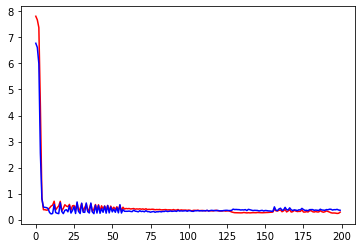

min train loss: 0.237
min valid loss: 0.219


In [9]:
# 训练 LSTM 模型;  ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
model.train()
epochs = 2000
train_epoch_loss = 0
train_epoch_loss_list = []
train_epoch_acc_list = []
valid_epoch_loss = 0
valid_epoch_loss_list = []
valid_epoch_acc_list = []

train_batch_count = train_x.shape[0]
valid_batch_count = valid_x.shape[0]

h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).float().to(device)
c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).float().to(device)


for epoch in range(epochs):
    batch_loss = []
    batch_mape = []
    batch_r2   = []
    train_epoch_loss = 0
    train_epoch_mape = 0
    train_epoch_r2 = 0
    train_pred_value_list = []
    train_real_value_list = []
    train_batch_list = list(range(0, train_batch_count))
    # random.shuffle(train_batch_list)
    for step in train_batch_list:
        train_pred, hn, cn = model(train_x[step], h0, c0)                                                    # pred: [batch_size, seq_len, out_dim]  但被修改成了 [batch_size, 1, out_dim]
        loss = loss_func(train_pred[:, -1, -1], train_y[step][:, -1, -1])                                    # 取batch里每个sequence最后一个预测输出来和实际
        train_pred_value_list.extend(list(train_pred[:, -1, -1].cpu().detach().flatten().numpy() ))
        train_real_value_list.extend(list(train_y[step][:, -1, -1].cpu().detach().flatten().numpy() ))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        batch_loss.append(loss.cpu().data.numpy())
        batch_mape.append(MAPE(train_pred[:, -1, -1], train_y[step][:, -1, -1]).item())
        batch_r2.append(R2(train_pred[:, -1, -1], train_y[step][:, -1, -1]).item())
    # print(batch_mape)
    train_epoch_loss = np.mean(batch_loss)
    train_epoch_mape = np.mean(batch_mape)
    train_epoch_r2 = np.mean(batch_r2)

    batch_loss = []
    batch_mape = []
    batch_r2 = []
    valid_epoch_loss = 0
    valid_epoch_mape = 0
    valid_epoch_r2 = 0
    valid_pred_value_list = []
    valid_real_value_list = []
    for step in range(valid_batch_count):
        valid_pred, hn, cn = model(valid_x[step], h0, c0)
        loss = loss_func(valid_pred[:, -1, -1], valid_y[step][:, -1, -1])
        valid_pred_value_list.extend(list(valid_pred[:, -1, -1].cpu().detach().flatten().numpy()))
        valid_real_value_list.extend(list(valid_y[step][ :, -1, -1].cpu().detach().flatten().numpy()))
        batch_loss.append(loss.cpu().data.numpy())
        batch_mape.append(MAPE(valid_pred[:, -1, -1], valid_y[step][:, -1, -1]).item())
        batch_r2.append(R2(valid_pred[:, -1, -1], valid_y[step][:, -1, -1]).item())
    # print(batch_loss)
    valid_epoch_loss = np.mean(batch_loss)
    valid_epoch_mape = np.mean(batch_mape)
    valid_epoch_r2 = np.mean(batch_r2)


    valid_epoch_loss_list.append(valid_epoch_loss)
    train_epoch_loss_list.append(train_epoch_loss)

    if ((epoch+1) % 10) == 0:
        print("{} of {} epoch \t train_loss: {:.3f} \t train_MAPE: {:.2%} \t train_r2: {:.3f} \t valid_loss: {:.3f} \t valid_MAPE: {:.2%} \t valid_r2: {:.3f}".format(epoch, epochs, train_epoch_loss, train_epoch_mape, train_epoch_r2, valid_epoch_loss, valid_epoch_mape, valid_epoch_r2))
    # print("{} of {} epoch \t train_loss: {:.3f} \t train_MAPE: {:.2%} \t train_r2: {:.3f} \t valid_loss: {:.3f} \t valid_MAPE: {:.2%} \t valid_r2: {:.3f}".format(epoch, epochs, train_epoch_loss, train_epoch_mape, train_epoch_r2, valid_epoch_loss, valid_epoch_mape, valid_epoch_r2))

    if train_epoch_loss < 0.1:
        print("{} of {} epoch \t train_loss: {:.3f} \t train_MAPE: {:.2%} \t train_r2: {:.3f} \t valid_loss: {:.3f} \t valid_MAPE: {:.2%} \t valid_r2: {:.3f}".format(epoch, epochs, train_epoch_loss, train_epoch_mape, train_epoch_r2, valid_epoch_loss, valid_epoch_mape, valid_epoch_r2))
        print("****************************************** STOP TRAIN  ****************************************")
        break

plt.plot(train_epoch_loss_list, 'r-')
plt.plot(valid_epoch_loss_list, 'b-')
plt.show()
print("min train loss: {:.3f}".format(min(train_epoch_loss_list)))
print("min valid loss: {:.3f}".format(min(valid_epoch_loss_list)))

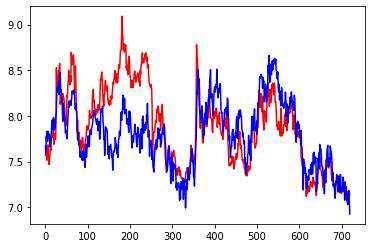

In [10]:
# 这是 train 的预测图形
plt.plot(train_real_value_list, 'r-')
plt.plot(train_pred_value_list, 'b-')
plt.show()
# print(train_real_value_list)

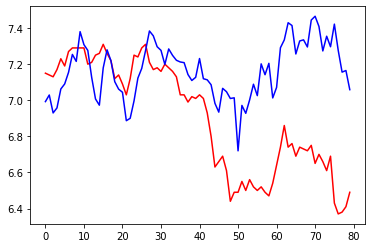

In [11]:
# 这是 vali的预测图形
plt.plot(valid_real_value_list, 'r-')
plt.plot(valid_pred_value_list, 'b-')
plt.show()

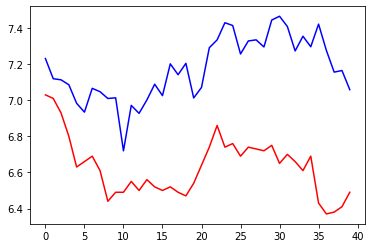

[7.03 7.01 6.93 6.8  6.63 6.66 6.69 6.61 6.44 6.49 6.49 6.55 6.5  6.56
 6.52 6.5  6.52 6.49 6.47 6.54 6.64 6.74 6.86 6.74 6.76 6.69 6.74 6.73
 6.72 6.75 6.65 6.7  6.66 6.61 6.69 6.43 6.37 6.38 6.41 6.49]
[7.2311916 7.119395  7.1132207 7.0859737 6.9829273 6.9341526 7.0660524
 7.0472627 7.0097713 7.013496  6.719655  6.971301  6.9274673 7.00145
 7.0887957 7.025648  7.2016754 7.1415133 7.204556  7.0128474 7.071073
 7.291066  7.3344975 7.4296794 7.4141855 7.2564764 7.328663  7.3347797
 7.295284  7.4445105 7.465602  7.4089055 7.273336  7.3548317 7.296584
 7.421872  7.2762837 7.1559052 7.1647787 7.058628 ]


In [12]:
# 这是 valid 最后一段的数据。误差累积到这里已经很大了。
plt.plot(valid_y[-1,:,-1,-1].cpu().detach().flatten().numpy(), 'r-')
plt.plot(valid_pred[:,-1].cpu().detach().flatten().numpy(), 'b-')
plt.show()
print(valid_y[-1,:,-1,-1].cpu().detach().flatten().numpy())
print(valid_pred[:,-1].cpu().detach().flatten().numpy())

Test Loss : 0.706
Test Prediction: 7.19
Test Actual:     6.48


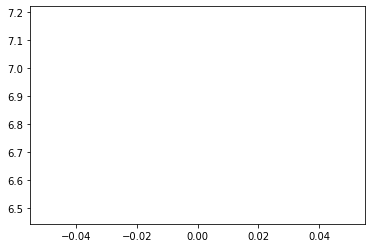

tensor([6.4800], device='cuda:0', dtype=torch.float64)
tensor([[7.1862]], device='cuda:0', grad_fn=<SelectBackward0>)


In [13]:
# 用模型预测数据
# 考虑到时序因素，这里的时候误差很大。
model.eval()
test_loss = 0

h0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).float().to(device)
c0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).float().to(device)

for step in range(test_x.shape[0]):
    pred, hn, cn = model(test_x[step], h0, c0)
    
    loss = loss_func(pred[:,-1,-1], test_y[step][:,-1,-1])               # Compare the all sequences' last element in one batch
    
    if test_x.shape[0] > 1:
        actual_line.append(test_y[step][-1,-1].item())
        pred_line.append(pred[-1,-1].item())
    elif test_x.shape[0] == 1:
        actual_line = test_y[step].cpu().detach().flatten().numpy()        # Only plot the last sequence of test batch
        pred_line   = pred[:,-1].cpu().detach().flatten().numpy()                # Only plot the last sequence of test batch
        
print("Test Loss : {:.3f}".format(loss.data))
print("Test Prediction: {:.2f}".format(float(pred[-1,-1].data)))
print("Test Actual:     {:.2f}".format(float(test_y[step][-1,-1].data)))


plt.plot(test_y[step,:,-1,-1].cpu().detach().flatten().numpy(), 'r--')
plt.plot(pred[:,-1].cpu().detach().flatten().numpy(), 'b-')
plt.show()
print(test_y[step,:,-1,-1])
print(pred[:,-1])

In [14]:
# 把rolling_data再分割为 train / test 就再预测
# 既然 预测值 和时序相关性很高，可以考虑太早的零星数据对于test影响不大，可以删掉
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)                   # 数据一共是 seq_count x seq_len x (x_in_dim+Y_SEQ_LEN) 

# 打乱train数据
# tmp_data = rolling_data[:-1]
# np.random.shuffle(tmp_data)
# rolling_data = np.concatenate((tmp_data, rolling_data[-1:]), axis=0)


print(rolling_data.shape)
print(TRAIN_BATCH_SIZE)
print(((rolling_data.shape[0]-1)//TRAIN_BATCH_SIZE)*TRAIN_BATCH_SIZE)
rolling_data = rolling_data[-((rolling_data.shape[0]-1)//TRAIN_BATCH_SIZE)*TRAIN_BATCH_SIZE-1:,]
print(rolling_data.shape)

train = rolling_data[:-1].reshape(-1, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-1:].reshape(1, 1, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                     # 把数据转成 test_batch_count x TEST_BATCH_SIZE x seq_len x in_dim 格式

train = torch.tensor(train).to(device)
test  = torch.tensor(test).to(device)

train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)
print(test_y)

(801, 25, 137)
40
800
(801, 25, 137)
torch.Size([20, 40, 25, 136]) torch.Size([20, 40, 1, 1])
torch.Size([1, 1, 25, 136]) torch.Size([1, 1, 1, 1])
tensor([[[[6.4800]]]], device='cuda:0', dtype=torch.float64)


9 of 200 epoch 	 train_loss: 0.490 	 train_MAPE: 6.05% 	 train_r2: -36.803
19 of 200 epoch 	 train_loss: 0.298 	 train_MAPE: 3.58% 	 train_r2: -12.274
29 of 200 epoch 	 train_loss: 0.678 	 train_MAPE: 8.38% 	 train_r2: -26.401
39 of 200 epoch 	 train_loss: 0.305 	 train_MAPE: 3.68% 	 train_r2: -8.311
49 of 200 epoch 	 train_loss: 0.432 	 train_MAPE: 5.34% 	 train_r2: -25.285
59 of 200 epoch 	 train_loss: 0.800 	 train_MAPE: 9.95% 	 train_r2: -42.069
69 of 200 epoch 	 train_loss: 0.432 	 train_MAPE: 5.30% 	 train_r2: -11.120
79 of 200 epoch 	 train_loss: 0.283 	 train_MAPE: 3.41% 	 train_r2: -9.577
89 of 200 epoch 	 train_loss: 0.283 	 train_MAPE: 3.43% 	 train_r2: -6.417
99 of 200 epoch 	 train_loss: 0.296 	 train_MAPE: 3.58% 	 train_r2: -4.030
109 of 200 epoch 	 train_loss: 0.254 	 train_MAPE: 3.02% 	 train_r2: -6.475
119 of 200 epoch 	 train_loss: 0.572 	 train_MAPE: 7.05% 	 train_r2: -16.960
129 of 200 epoch 	 train_loss: 0.972 	 train_MAPE: 12.14% 	 train_r2: -46.548
139 of 200 epo

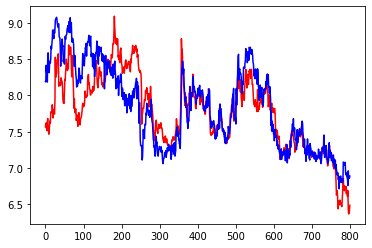

min train loss: 0.248


In [15]:
# 再重新生成模型再 train 模型
model = LSTMModel(input_size=train_x.shape[3], hidden_dim_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, seq_len=train_x.shape[2], output_dim_size=1).float().to(device)
LR = 1e-4
# loss_func = nn.MSELoss(reduction="mean")
loss_func = RMSE
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)
model.train()
epochs = 200

train_epoch_loss_list = []
valid_epoch_loss_list = []

h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).float().to(device)
c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).float().to(device)


for epoch in range(epochs):
    batch_loss = []
    batch_mape = []
    batch_r2   = []
    train_epoch_loss = 0
    train_pred_value_list = []
    train_real_value_list = []
    train_batch_list = list(range(0, train_batch_count))
    # random.shuffle(train_batch_list)
    for step in range(0, train_x.shape[0]):
        train_pred, hn, cn = model(train_x[step], h0, c0)
        loss = loss_func(train_pred[:,-1,-1], train_y[step][:,-1,-1])                # Compare the all sequences' last element in one batch
        train_pred_value_list.extend(list(train_pred[:,-1,-1].cpu().detach().flatten().numpy() ))
        train_real_value_list.extend(list(train_y[step,:,-1,-1].cpu().detach().flatten().numpy() ))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        batch_loss.append(loss.cpu().data.numpy())
        batch_mape.append(MAPE(train_pred[:, -1, -1], train_y[step][:, -1, -1]).item())
        batch_r2.append(R2(train_pred[:, -1, -1], train_y[step][:, -1, -1]).item())
    train_epoch_loss = np.mean(batch_loss)
    
    batch_loss = []
    valid_epoch_loss = 0
    valid_pred_value_list = []
    valid_real_value_list = []
    for step in range(valid_batch_count):
        valid_pred, hn, cn = model(valid_x[step], h0, c0)
        loss = loss_func(valid_pred[:,-1], valid_y[step][:,-1,-1])
        valid_pred_value_list.extend(list(valid_pred[:,-1].cpu().detach().flatten().numpy()))
        valid_real_value_list.extend(list(valid_y[step,:,-1,-1].cpu().detach().flatten().numpy()))
        batch_loss.append(loss.cpu().data.numpy())
    valid_epoch_loss = np.mean(batch_loss)
    
    valid_epoch_loss_list.append(valid_epoch_loss)
    train_epoch_loss_list.append(train_epoch_loss)
    
    if ((epoch+1) % 10) == 0:
        print("{} of {} epoch \t train_loss: {:.3f} \t train_MAPE: {:.2%} \t train_r2: {:.3f}".format(epoch, epochs, np.mean(batch_loss), np.mean(batch_mape), np.mean(batch_r2)))

    if np.mean(batch_loss)<0.05:
        print("{} of {} epoch got the smallest epoch train loss: {:.3f}".format(epoch, epochs, np.mean(batch_loss)))
        break

plt.plot(train_epoch_loss_list, 'r-')
plt.plot(valid_epoch_loss_list, 'b-')
plt.show() 
print("min train loss: {:.3f}".format(min(train_epoch_loss_list)))

In [16]:
print(train_pred.shape)
print(train_y.shape)

print(train_y[-1,-1])
print(train_pred[-1,-1])

torch.Size([40, 25, 1])
torch.Size([20, 40, 1, 1])
tensor([[6.4900]], device='cuda:0', dtype=torch.float64)
tensor([6.8902], device='cuda:0', grad_fn=<SelectBackward0>)


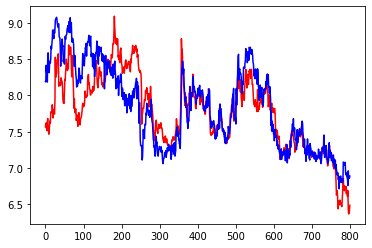

In [17]:
plt.plot(valid_real_value_list, 'r-')
plt.plot(valid_pred_value_list, 'b-')
plt.show()

In [18]:
# print(train_x.shape)
# print(test_x.shape)
print(train_real_value_list[-1])
print(train_pred_value_list[-1])

6.49
6.8902197


In [19]:
model.eval()

h0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).float().to(device)
c0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).float().to(device)

pred, hn, cn = model(test_x[-1], h0, c0)

print(test_y.shape)
print(pred.shape)
print("Real: {:.2f}".format(test_y.item()))
print("Pred: {:.2f}".format(pred[:,-1,:].item()))

loss = loss_func(pred[:,-1,-1], test_y[-1][:,-1,-1])
print("loss: {:.3f}".format(loss.item()))

torch.Size([1, 1, 1, 1])
torch.Size([1, 25, 1])
Real: 6.48
Pred: 6.86
loss: 0.383


In [20]:
# 保存模型
torch.save(model, 'e:\\Model_601229_qfq.pkl')